# 1. Camera Calibration

This script intends to calibrate a camera using an object.
For this implementation we will use the Zhang's calibration method.

**Import the libraries**

In [4]:
#%matplotlib notebook 

In [5]:
from matplotlib import pyplot as plt
import numpy as np
from camera_models import *  # our package
import cv2

DECIMALS = 2  # how many decimal places to use in print


## Zhang's Method
Comparing to the DLT method, the Zhang method only calculate the intrinsic parameters. We instead only need to find 5 parameters.

### Implementation:

## 1. Import the 2D and 3D coordinates
This is example is not completely right since we need more than 3 diferent views to estimate H using Zhang's method.

In [6]:

#worldcoo = np.array([ (0,0,0), (0,28,0), (56,0,0), (56,28,0), (56,84,0), (84,84,0), (112,56,0),
#             (112,84,0), (84,56,0), (84,112,0), (0,28,28), (0,28,56), (0,56,28), (0,56,56), 
#             (0,56,84), (0,56,112), (0,112,0), (0,112,28), (0,112,56), (0,112,84), (0,112,112) 
#           ])

#imagecoo = np.array([ (1549, 1599), (1547, 1763), (1797, 1625), (1793, 1807), (1785, 2156), (1918, 2196),
#            (2069, 2051), (2061, 2233), (1928, 2015), (1915, 2366), (1413, 1781), (1280, 1807),
#             (1415, 1958), (1283, 1981), (1139, 2013), (990, 2041), (1541, 2251), (1420, 2287),
#             (1292, 2320), (1149, 2356), (1005, 2401)
#           ])
#print("World coordinate have : "+str(worldcoo.shape)+ " dimensions\n")
#print("Image coordinate have : "+str(imagecoo.shape)+ " dimensions\n")

We need to **remove the Z coordinate** from the World coordinate since we are using the chessboard calibration

In [7]:
def to_inhomogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("x must be one-dimensional.")

    return (X / X[-1])[:-1]


def to_homogeneous(X: np.ndarray) -> np.ndarray:
    if X.ndim > 1:
        raise ValueError("X must be one-dimensional.")

    return np.hstack([X, 1])


def to_homogeneous_arr(X: np.ndarray) -> np.ndarray:
    one_matrix = np.ones((X.shape[0],1))

    out_value = np.concatenate((X, one_matrix), axis=1)

    return out_value
    
def _get_roll_matrix(theta_x: float = 0.0) -> np.ndarray:
    Rx = np.array(
        [
            [1.0, 0.0, 0.0],
            [0.0, np.cos(theta_x), -np.sin(theta_x)],
            [0.0, np.sin(theta_x), np.cos(theta_x)],
        ]
    )
    return Rx


def _get_pitch_matrix(theta_y: float = 0.0) -> np.ndarray:
    Ry = np.array(
        [
            [np.cos(theta_y), 0.0, np.sin(theta_y)],
            [0.0, 1.0, 0.0],
            [-np.sin(theta_y), 0.0, np.cos(theta_y)],
        ]
    )
    return Ry


def _get_yaw_matrix(theta_z: float = 0.0) -> np.ndarray:
    Rz = np.array(
        [
            [np.cos(theta_z), -np.sin(theta_z), 0.0],
            [np.sin(theta_z), np.cos(theta_z), 0.0],
            [0.0, 0.0, 1.0],
        ]
    )
    return Rz


#my and mx correspond to the pixel density in the x and y direction
def get_calibration_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = np.diag([mx, my, 1]) @ np.array([[f, 0.0, px], [0.0, f, py], [0.0, 0.0, 1.0]])
    return K

def get_rotation_matrix(
    theta_x: float = 0.0, theta_y: float = 0.0, theta_z: float = 0.0
) -> np.ndarray:
    # Roll
    Rx = _get_roll_matrix(theta_x)
    # Pitch
    Ry = _get_pitch_matrix(theta_y)
    # Yaw
    Rz = _get_yaw_matrix(theta_z)
    return Rz @ Ry @ Rx

def get_translation_matrix(Tx: float,Ty: float,Tz: float):
    return np.array([[Tx],[Ty],[Tz]])

def get_extrinsic_matrix(rot: np.array((3,3)), trans:np.array((3,1))):
    E = np.concatenate((rot,trans), axis = 1)
    return E

def get_projection_matrix(
    f: float,
    px: float = 0.0,
    py: float = 0.0,
    tx : float = 0.0,
    ty : float = 0.0,
    tz : float = 0.0,
    theta_x: float = 0.0,
    theta_y: float = 0.0,
    theta_z: float = 0.0,
    mx: float = 1.0,
    my: float = 1.0,
) -> np.ndarray:
    K = get_calibration_matrix(f=f, px=px, py=py, mx=mx, my=my)
    #print("Calibration matrix: \n",K)
    R = get_rotation_matrix(theta_x=theta_x, theta_y=theta_y, theta_z=theta_z)
    #print("Rotation matrix: \n",R)
    T = get_translation_matrix(tx,ty,tz)
    #print("Translation matrix: \n",T)
    E = get_extrinsic_matrix(rot = R,trans = T)
    P = K @ E
    
    return P,E

def get_plucker_matrix(A: np.ndarray, B: np.ndarray) -> np.ndarray:
    A = to_homogeneous(A)
    B = to_homogeneous(B)
    L = A.reshape(-1, 1) * B.reshape(1, -1) - B.reshape(-1, 1) * A.reshape(1, -1)
    return L

def create_chessboard(patternsize_x,patternsize_y):
    """
    Creates chessboard with pattern dimensions
    patternsize_x[in] - size x of the chessboard
    patternsize_y[in] - size y of the chessboard
    world_pts_arr[out] - meshgrid points
    """
    pattern_size_x,pattern_size_y = (patternsize_x,patternsize_y)

    X = np.linspace(-pattern_size_x/2, pattern_size_x/2,pattern_size_x + 1)
    Y = np.linspace(-pattern_size_y/2, pattern_size_y/2,pattern_size_y + 1)

    zdata = np.zeros((patternsize_x + 1,patternsize_y + 1))
    xdata, ydata = np.meshgrid(X, Y)

    xdata_ = xdata.flatten()
    ydata_ = ydata.flatten()
    zdata_ = zdata.flatten()
    onedata = np.ones((zdata_.shape[0])).flatten()
    # homogeneous coordinates
    world_pts =([xdata_,ydata_,zdata_,onedata])
    world_pts_arr = np.array(world_pts).T

    return world_pts_arr

def get_chessboard_rot_trans(world_pts_arr,rx, ry, rz, tx,ty,tz):
    """
    rotates and translates the chessboard
    world_pts_arr[in] - chessboard points in homogenous coordinates[4,1]
    rx[in] - rotation on the x axis
    ry[in] - rotation on the y axis
    rz[in] - rotation on the z axis
    tx[in] - translation on the x axis
    ty[in] - translation on the y axis
    tz[in] - translation on the z axis
    world_trans_arr[out] - output chessboard rotation and translation 
    """ 
    
    Rx =get_rotation_matrix(rx,ry,rz)
    Trans = np.array([[tx],[ty],[tz]])
    E = np.concatenate((Rx,Trans),axis=1)

    world_trans_arr = np.dot(world_pts_arr,E.T)

    return world_trans_arr

def get_image_points(F,chess_pts,px,py,trans_x = 0,trans_y = 0,trans_z = 0,theta_x=  0,theta_y= np.pi ,theta_z= np.pi):

    K = get_calibration_matrix(F, px=px, py=py)                                                                                                     # calibration matrix
    P,E = get_projection_matrix(F, px=px, py=py,tx = trans_x,ty = trans_y, tz = trans_z,theta_x = theta_x,theta_y = theta_y,theta_z=theta_z)        # projection matrix

    print("\nCalibration matrix (K):\n", K)
    print("\nProjection matrix (P):\n", P)
    print("\nExtrinsic matrix (E):\n", E)

    if( len(chess_pts.shape) == 3):
        x_arr = np.zeros((chess_pts.shape[0],chess_pts.shape[1],2))
        # goes through the different planes
        for i in range(chess_pts.shape[0]):                                                                                                              # chooses a plane
            for j in range(chess_pts.shape[1]):
                Xh = to_homogeneous(chess_pts[i,j,:])
                xh = P @ Xh
                x_arr[i,j,:] = to_inhomogeneous(xh)
    else:
        x_arr = np.zeros((chess_pts.shape[0],2))
        # goes through the different planes
        for i in range(chess_pts.shape[0]):                                                                                                              # chooses a plane
            Xh = to_homogeneous(chess_pts[i,:])
            xh = P @ Xh
            x_arr[i,:] = to_inhomogeneous(xh)
            

    return x_arr, chess_pts

### Chessboard representation in space
Using meshgrid, we obtain a (6,8) ideal chessboard with 25mm

In [8]:
F = 16                                       # focal length( in mm )
sensor_size = np.array([11,7])              # sensor size(mm)
PX= sensor_size[0]/2.0                      # principal point x-coordinate
PY= sensor_size[1]/2.0                      # principal point y-coordinate
IMAGE_HEIGTH = sensor_size[1]
IMAGE_WIDTH = sensor_size[0]
THETA_X = -np.pi / 2                         # roll angle
THETA_Z = -np.pi/2                             # yaw angle

C = np.array([6, -5, 2])                    # camera centre


Extrinsic
: [[ 1.00000000e+00 -1.22464680e-16 -1.22464680e-16  4.00000000e+00]
 [-1.22464680e-16 -1.00000000e+00  1.49975978e-32  4.00000000e+00]
 [-1.22464680e-16  0.00000000e+00 -1.00000000e+00  4.00000000e+00]]


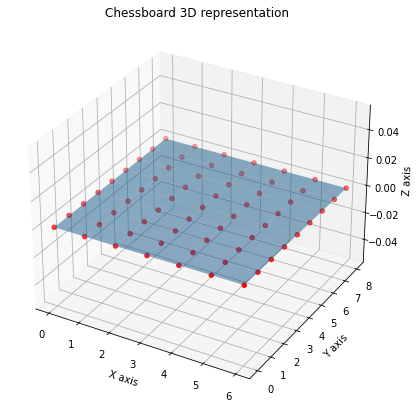

In [9]:
pattern_size_x,pattern_size_y = (6,8)

X = np.linspace(0, pattern_size_x,pattern_size_x + 1)
Y = np.linspace(0, pattern_size_y,pattern_size_y + 1)

zdata = np.zeros((9,7))
xdata, ydata = np.meshgrid(X, Y)


fig = plt.figure(figsize = (11,7))
ax = plt.axes(projection='3d')


P,E = get_projection_matrix(F, px=PX, py=PY,tx = 4,ty = 4, tz = 4,theta_x=  0,theta_y= np.pi ,theta_z= np.pi)      # projection matrix

print("Extrinsic\n:",E)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='prism')
ax.set_title("Chessboard 3D representation")
ax.plot_surface(xdata, ydata, zdata, alpha=0.5)  # the horizontal plane
ax.set_xlabel("X axis")
ax.set_ylabel("Y axis")
ax.set_zlabel("Z axis")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


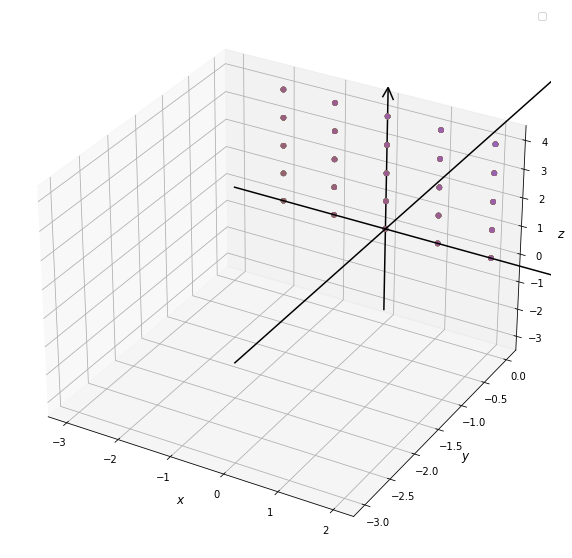

In [10]:
world_pts = create_chessboard(4,4)

chess_points = get_chessboard_rot_trans(world_pts,0,np.pi/2,np.pi/2,0,0,2)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

for i in range(len(chess_points)):
    #ax.quiver(0,0,0,world_trans_arr[:,0],world_trans_arr[:,1],world_trans_arr[:,2], color='C1', arrow_length_ratio=0.1, label=r'$\vec{u}$')
    ax.scatter3D(chess_points[:,0],chess_points[:,1],chess_points[:,2], cmap='prism')

plt.legend()
ax.set_xlabel(r'$x$', fontsize='large')
ax.set_ylabel(r'$y$', fontsize='large')
ax.set_zlabel(r'$z$', fontsize='large')
ax.quiver(-3, 0, 0, 8, 0, 0, color='k', arrow_length_ratio=0.05) # x-axis
ax.quiver(0, -3, 0, 0, 8, 0, color='k', arrow_length_ratio=0.05) # y-axis
ax.quiver(0, 0, -3, 0, 0, 8, color='k', arrow_length_ratio=0.05) # z-axis

plt.show()


[[-8.  0.  2.]
 [-8. -1.  2.]
 [-8. -2.  2.]
 [-8. -3.  2.]
 [-8. -4.  2.]
 [-8.  0.  3.]
 [-8. -1.  3.]
 [-8. -2.  3.]
 [-8. -3.  3.]
 [-8. -4.  3.]
 [-8.  0.  4.]
 [-8. -1.  4.]
 [-8. -2.  4.]
 [-8. -3.  4.]
 [-8. -4.  4.]
 [-8.  0.  5.]
 [-8. -1.  5.]
 [-8. -2.  5.]
 [-8. -3.  5.]
 [-8. -4.  5.]
 [-8.  0.  6.]
 [-8. -1.  6.]
 [-8. -2.  6.]
 [-8. -3.  6.]
 [-8. -4.  6.]]
[-8.  0.  2.]
[-8. -1.  2.]
[-8. -2.  2.]
[-8. -3.  2.]
[-8. -4.  2.]
[-8.  0.  3.]
[-8. -1.  3.]
[-8. -2.  3.]
[-8. -3.  3.]
[-8. -4.  3.]
[-8.  0.  4.]
[-8. -1.  4.]
[-8. -2.  4.]
[-8. -3.  4.]
[-8. -4.  4.]
[-8.  0.  5.]
[-8. -1.  5.]
[-8. -2.  5.]
[-8. -3.  5.]
[-8. -4.  5.]
[-8.  0.  6.]
[-8. -1.  6.]
[-8. -2.  6.]
[-8. -3.  6.]
[-8. -4.  6.]


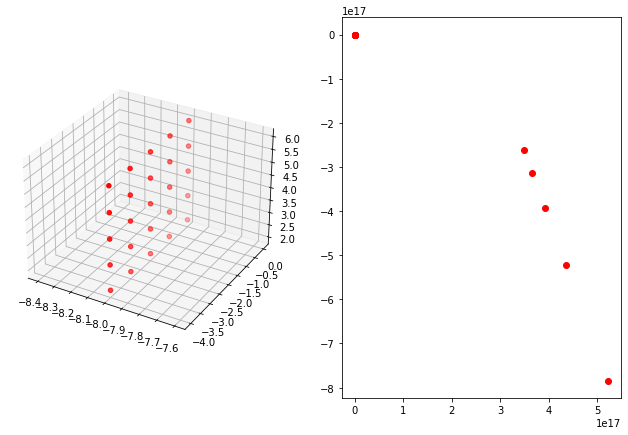

In [11]:
# intrinsic matrix 
K = get_calibration_matrix(F, px=PX, py=PY)     # calibration matrix
P,E = get_projection_matrix(F, px=PX, py=PY,tx = 2,ty = 2, tz = 2,theta_x=  np.pi/2,theta_y= 0.0 ,theta_z= np.pi/2)      # projection matrix

#print("Extrinsic Matrix:\n",E)
#print("Projection Matrix:\n",P)
world_origin = np.zeros(3)  # world location(0,0,0)
dx, dy, dz = E[:,:3].T      # rotation   
dxo, dyo, dzo = np.eye(3)   # creates a 1's diagonal( Origin)

#world frame
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dxo, 
    dy=dyo,
    dz=dzo,
    name="World",
)

#camera frame -> 
camera_frame = ReferenceFrame(
    origin=E[:,3].T,
    dx=dx, 
    dy=dy,
    dz=dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="Image",
)

image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)



#draw3d_arrow(world_origin, E[:,3].T, color="tab:red", name="t")        # draw arrow to connect 
# chessboard print
world_pts = create_chessboard(4,4)
#print(world_pts)
checker_points = get_chessboard_rot_trans(world_pts,np.pi/2,0,-np.pi/2,-8,-2,4)
print(checker_points)
# plot
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(121,projection = '3d')
ax1 =fig.add_subplot(122)

ax.scatter3D(checker_points[:,0],checker_points[:,1],checker_points[:,2],color = 'r')
if( len(checker_points.shape) == 3):
    x_arr = np.zeros((checker_points.shape[0],checker_points.shape[1],2))
    # goes through the different planes
    for i in range(checker_points.shape[0]):                                                                                                              # chooses a plane
        for j in range(checker_points.shape[1]):
            Xh = to_homogeneous(checker_points[i,j,:])
            xh = P @ Xh
            x_arr[i,j,:] = to_inhomogeneous(xh)
else:
    x_arr = np.zeros((checker_points.shape[0],2))
    # goes through the different planes
    for i in range(checker_points.shape[0]): 
        print(checker_points[i,:])                                                                                                             # chooses a plane
        Xh = to_homogeneous(checker_points[i,:])
        xh = P @ Xh
        x_arr[i,:] = to_inhomogeneous(xh)

ax1.scatter(x_arr[:,0],x_arr[:,1],color = 'r')
    
plt.show()
   


- Need to define the intrinsic matrix for the camera
- Get multiple extrinsic matrixes for diferent views of the chessboard

[[ 6.12323400e-17  1.00000000e+00  0.00000000e+00]
 [-6.12323400e-17  3.74939946e-33 -1.00000000e+00]
 [-1.00000000e+00  6.12323400e-17  6.12323400e-17]]
[[-2. -2.  0.  1.]
 [-1. -2.  0.  1.]
 [ 0. -2.  0.  1.]
 [ 1. -2.  0.  1.]
 [ 2. -2.  0.  1.]
 [-2. -1.  0.  1.]
 [-1. -1.  0.  1.]
 [ 0. -1.  0.  1.]
 [ 1. -1.  0.  1.]
 [ 2. -1.  0.  1.]
 [-2.  0.  0.  1.]
 [-1.  0.  0.  1.]
 [ 0.  0.  0.  1.]
 [ 1.  0.  0.  1.]
 [ 2.  0.  0.  1.]
 [-2.  1.  0.  1.]
 [-1.  1.  0.  1.]
 [ 0.  1.  0.  1.]
 [ 1.  1.  0.  1.]
 [ 2.  1.  0.  1.]
 [-2.  2.  0.  1.]
 [-1.  2.  0.  1.]
 [ 0.  2.  0.  1.]
 [ 1.  2.  0.  1.]
 [ 2.  2.  0.  1.]]
[[8. 0. 0.]
 [8. 1. 0.]
 [8. 2. 0.]
 [8. 3. 0.]
 [8. 4. 0.]
 [8. 0. 1.]
 [8. 1. 1.]
 [8. 2. 1.]
 [8. 3. 1.]
 [8. 4. 1.]
 [8. 0. 2.]
 [8. 1. 2.]
 [8. 2. 2.]
 [8. 3. 2.]
 [8. 4. 2.]
 [8. 0. 3.]
 [8. 1. 3.]
 [8. 2. 3.]
 [8. 3. 3.]
 [8. 4. 3.]
 [8. 0. 4.]
 [8. 1. 4.]
 [8. 2. 4.]
 [8. 3. 4.]
 [8. 4. 4.]]
[8. 0. 0.]
[8. 1. 0.]
[8. 2. 0.]
[8. 3. 0.]
[8. 4. 0.]
[8. 0. 1.]
[8.

C:\Users\UX550\AppData\Local\Temp\ipykernel_25120\1380734890.py:5: RuntimeWarning: divide by zero encountered in true_divide
  return (X / X[-1])[:-1]
C:\Users\UX550\AppData\Local\Temp\ipykernel_25120\1380734890.py:5: RuntimeWarning: invalid value encountered in true_divide
  return (X / X[-1])[:-1]


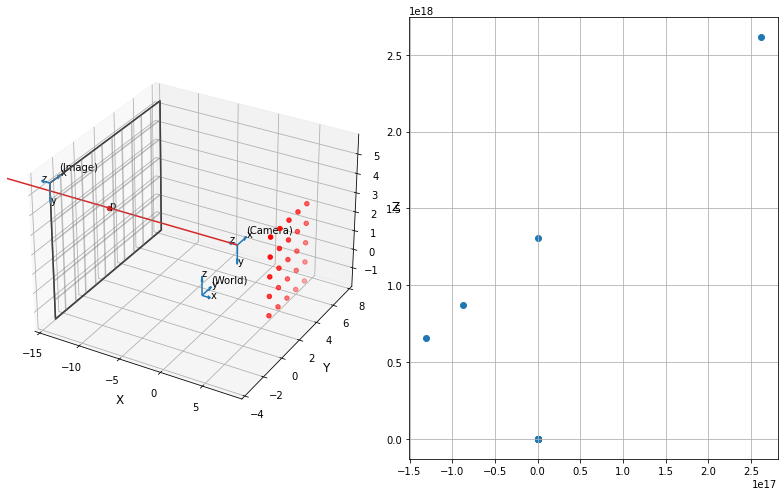

In [12]:
# intrinsic matrix 
K = get_calibration_matrix(F, px=PX, py=PY)     # calibration matrix
P,E = get_projection_matrix(F, px=PX, py=PY,tx = 2,ty = 2, tz = 2,theta_x= -np.pi/2,theta_y= 0.0 ,theta_z= np.pi/2)      # projection matrix

R = get_rotation_matrix(theta_x=THETA_X, theta_z=THETA_Z)

#print("Extrinsic Matrix:\n",E)
#print("Projection Matrix:\n",P)
world_origin = np.zeros(3)  # world location(0,0,0)
dx, dy, dz = E[:,:3].T      # rotation   

print(E[:,:3].T)
dxo, dyo, dzo = np.eye(3)   # creates a 1's diagonal( Origin)

#world frame
world_frame = ReferenceFrame(
    origin=world_origin, 
    dx=dxo, 
    dy=dyo,
    dz=dzo,
    name="World",
)

#camera frame -> 
camera_frame = ReferenceFrame(
    origin=E[:,3].T,
    dx=dx, 
    dy=dy,
    dz=dz,
    name="Camera",
)
Z = PrincipalAxis(
    camera_center=camera_frame.origin,
    camera_dz=camera_frame.dz,
    f=F,
)
image_frame = ReferenceFrame(
    origin=Z.p - camera_frame.dx * PX - camera_frame.dy * PY, 
    dx=dx, 
    dy=dy,
    dz=dz,
    name="Image",
)

image_plane = ImagePlane(
    origin=image_frame.origin, 
    dx=image_frame.dx, 
    dy=image_frame.dy, 
    heigth=IMAGE_HEIGTH,
    width=IMAGE_WIDTH,
)

#draw3d_arrow(world_origin, E[:,3].T, color="tab:red", name="t")        # draw arrow to connect 
# chessboard print
world_pts = create_chessboard(4,4)
print(world_pts)
checker_points = get_chessboard_rot_trans(world_pts,np.pi/2,0,np.pi/2,8,2,2)
print(checker_points)

if( len(checker_points.shape) == 3):
    x_arr = np.zeros((checker_points.shape[0],checker_points.shape[1],2))
    # goes through the different planes
    for i in range(checker_points.shape[0]):                                                                                                              # chooses a plane
        for j in range(checker_points.shape[1]):
            Xh = to_homogeneous(checker_points[i,j,:])
            xh = P @ Xh
            x_arr[i,j,:] = to_inhomogeneous(xh)
else:
    x_arr = np.zeros((checker_points.shape[0],2))
    # goes through the different planes
    for i in range(checker_points.shape[0]): 
        print(checker_points[i,:])                                                                                                             # chooses a plane
        Xh = to_homogeneous(checker_points[i,:])
        xh = P @ Xh
        x_arr[i,:] = to_inhomogeneous(xh)

# plot
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(121,projection = '3d')
world_frame.draw3d()
camera_frame.draw3d()
image_frame.draw3d()
Z.draw3d()
image_plane.draw3d()


ax.scatter3D(checker_points[:,0],checker_points[:,1],checker_points[:,2],color = 'r')
ax.set_xlabel('X', fontsize='large')
ax.set_ylabel('Y', fontsize='large')
ax.set_zlabel('Z', fontsize='large')
ax1 = fig.add_subplot(122)
ax1.scatter(x_arr[:,0],x_arr[:,1])
ax1.grid()
#ax1.set_xlim([0,5])
#ax1.set_ylim([0,2])
plt.tight_layout()
plt.show()

plt.show()


In [13]:
# chessboard print
chess_pts = []
world_pts = create_chessboard(4,4)
rotangles = [[np.pi/2,0,np.pi/2],[-np.pi/3,0,np.pi/2],[np.pi/3,0,np.pi/2],[np.pi/2,0,np.pi/3],[np.pi/2,0,-np.pi/3]]
transangles =  [[10,2,2],[11,2,2],[12,2,2],[13,2,2],[14,2,2],[15,2,2],[10,3,2],[11,3,2],[12,3,2],[13,3,2],[14,3,2],[15,3,2]]

for i in range(len(transangles)):
    for j in range(len(rotangles)):    
        chess_pts.append(get_chessboard_rot_trans(world_pts,rotangles[j][0],rotangles[j][1],rotangles[j][2],transangles[i][0],transangles[i][1],transangles[i][2]))

chess_pts_arr = np.array(chess_pts)
chess_pts_arr.shape

(60, 25, 3)

In [14]:


x_arr, world_pts_arr = get_image_points(chess_pts_arr[:1,:,:],px = PX, py = PY,trans_x = 2,trans_y = 4, trans_z = 4,theta_x= np.pi/2,theta_y= 0.0 ,theta_z= np.pi/2)
K = get_calibration_matrix(3, px=PX, py=PY)                                                                                                     # calibration matrix
print("\nCalibration matrix (K):\n", K)
fig = plt.figure(figsize=(11,7))
ax = fig.add_subplot(projection = '3d')
ax.scatter(x_arr[0,:,0],x_arr[0,:,1])
plt.show()


TypeError: get_image_points() missing 1 required positional argument: 'chess_pts'

In [ ]:
world_pts_arr[0,:]

In [ ]:
nzeros=  np.zeros((world_pts_arr.shape[0],world_pts_arr.shape[1],1))
world_pts_arr[:,:,2:] = nzeros
print(world_pts_arr)
world_pts_arr = np.float32(world_pts_arr)
x_arr = np.float32(x_arr)
x_arr

In [ ]:
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints,(10,12), None, None)

In [ ]:
world_pts_arr[0,:,:]
objpoints=[]
objpoints.append(world_pts_arr)

imgpoints = []
imgpoints.append(x_arr)
objpoints

## 2. Normalize matrix
Normalization of input data. To improve numerical stability of the calculations, it is recommended to normalize both 2D point sets X and x before performing the homography estimation. Burger[pag.14]

In [ ]:
# Normalizing a given 2D point set is accomplished by shifting and scaling all points such that the centroid od the 
# transformed set is aligned with the origin and its diameter has a predefined size.
# There are various methods in the literature to calculate the normalization. In this case, the method used is 
# applied scaling non-unformly in x- and y- direction such that the variances along both axis get normalized. Burger[appendix B, pag 46]
def matrix_normalization(data):
    """
       Args:
          data: Nx2 stack of data points
        Returns:
          The normalization matrix
    """
    if data.ndim != 2 or data.shape[-1] != 2:
        raise ValueError('Dataset must be a collection of 2D points')

    x, y = data[:, 0], data[:, 1]

    N = data.shape[0]

    x_mean, y_mean = x.mean(), y.mean()
    x_var, y_var = x.var(), y.var()
    
    # Form rescaling matrix so that data points will lie
    # sqrt(2) from the origin on average.
    s_x, s_y = np.sqrt(2. / x_var), np.sqrt(2. / y_var)
    
    norm_matrix = np.array([[s_x,  0., -s_x * x_mean],
                            [ 0., s_y, -s_y * y_mean],
                            [ 0.,  0.,            1.]])

    return norm_matrix


## 3. Homography estimation with the DLT

### 3.1 Solving homogeneous systems of linear equations: **SVD**
**goal : find the homography matrix (H)** 
- Normalization matrix
- Apply the matrix to the coordinates
- Homogenous coordinates transformation
- Having a system M*h = , we apply SVD(M). 
- Denormalize the matrix

In [ ]:
def homography_matrix(imagecoo,worldcoo):
    # get the shape of the matrix
    worldm, worldn = worldcoo.shape
    imagem, imagen = imagecoo.shape

    homo_world = np.append(worldcoo,np.ones((worldm,1)),axis = 1)
    homo_image = np.append(imagecoo,np.ones((imagem,1)),axis = 1)


    # world coordinate normalization
    X_matrix_norm = matrix_normalization(worldcoo)
    # image coordinate normalization
    x_matrix_norm = matrix_normalization(imagecoo)
    
    # Normalize the coordinates
    world_norm = np.dot(homo_world,X_matrix_norm.T)
    image_norm = np.dot(homo_image,x_matrix_norm.T)

    #2D DLT
    X, Y, x, y = world_norm[:,0],world_norm[:,1], image_norm[:,0], image_norm[:,1]

    A = np.zeros((worldm * 2, 9))

    M_x = np.zeros((worldm, 9))
    M_x[:, 0] = -X
    M_x[:, 1] = -Y
    M_x[:, 2] = -1.
    M_x[:, 6] =  x * X
    M_x[:, 7] =  x * Y
    M_x[:, 8] =  x

    M_y = np.zeros((worldm, 9))
    M_y[:, 3] = -X
    M_y[:, 4] = -Y
    M_y[:, 5] = -1.
    M_y[:, 6] =  y * X
    M_y[:, 7] =  y * Y
    M_y[:, 8] =  y

    # Note that all x-constraints precede all y-constraints for convenience of 
    # representation.
    A[:worldm] = M_x
    A[worldm:] = M_y

    U, S, V = np.linalg.svd(A)
    # get the min Singular value
    idx = np.argmin(S)
    H = V[idx].reshape(3,3)
    
    # Denormalize the coordinates
    H = np.dot(np.dot(np.linalg.inv(x_matrix_norm), H), X_matrix_norm)
    #print("Homography Matrix: \n"+str(H))
    return H




## Obtain the Corner information of images

### Finding the corner of the checkerboard
+ With 9 images, each one with 48 image points
+ The checkerboard has 25mm between corners

In [ ]:
# number of images
n_imgs = 9
# pattern size
patternsize= (6,8)
#distance between squares(in mm)
dist = 25

# specified number of iterations are completed.
criteria = (cv2.TERM_CRITERIA_EPS +
            cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Vector for 3D points
threedpoints = []
 
# Vector for 2D points
twodpoints = []

#3D points real world coordinates( static -> chessboard)
# create a matrix of zeros for 48 points , each with 3 coordinates
world_coo = np.zeros((1, patternsize[0]* patternsize[1],3), np.float32)
world_coo[:, :, :2] = np.mgrid[0:patternsize[0], 0:patternsize[1]].T.reshape(-1, 2)
# Transform coordinates in mm
world_coo = world_coo*dist

#prev_img_shape = None

for i in range(n_imgs):
    
    name = ("images/Chessboard_real_"+ str(i+1)+".jpeg")
    #Import the image
    img = cv2.imread(name)
    # convert it to gray scale
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    
    retval, corners= cv2.findChessboardCorners(gray,patternsize,cv2.CALIB_CB_ADAPTIVE_THRESH + cv2.CALIB_CB_FAST_CHECK +cv2.CALIB_CB_NORMALIZE_IMAGE)
    
    if(retval == True):
        threedpoints.append(world_coo)

        # Refining pixel coordinates or given 2d points.
        corners2 = cv2.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria).reshape(48,2)

        twodpoints.append(corners2)
        # Draw and display the corners
        image = cv2.drawChessboardCorners(img,patternsize,corners2,retval)
        plt.imshow(image)
        #plt.show()

# image coordinates and world coordinates for the diferent images( the world coordinates are always the same)
imagecoo = np.asarray(twodpoints)
worldcoo = np.asarray(threedpoints) 


In [ ]:
# empty list to store the homographies
H = np.zeros((n_imgs,3,3))

for i in range(n_imgs):
    im = imagecoo[i][:][:].reshape(48,2)
    wo = worldcoo[0][:].reshape(48,3)
    # remove the Z coordinate
    wo = wo[:,:2]
    H[i,:] = homography_matrix(im,wo)
    


## 4. Determining the intrinsic camera parameters
Use the computed homographies to calculate the intrisic matrix \
Since H has **8DoF, it's needed >= 4 points to estimate the homography**

### 4.1 Generate $V_{pq}$

In [ ]:
def generate_v(H_stack, i, j):
    """Generate intrinsic orthogonality constraints. See Zhang pg. 6 for
       details.
    """ 
    M = H_stack.shape[0]

    v_ij = np.zeros((M, 6))
    v_ij[:, 0] = H_stack[:, 0, i] * H_stack[:, 0, j]
    v_ij[:, 1] = H_stack[:, 0, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 0, j]
    v_ij[:, 2] = H_stack[:, 1, i] * H_stack[:, 1, j]
    v_ij[:, 3] = H_stack[:, 2, i] * H_stack[:, 0, j] + H_stack[:, 0, i] * H_stack[:, 2, j]
    v_ij[:, 4] = H_stack[:, 2, i] * H_stack[:, 1, j] + H_stack[:, 1, i] * H_stack[:, 2, j]
    v_ij[:, 5] = H_stack[:, 2, i] * H_stack[:, 2, j]

    return v_ij


### 4.2 Compute the intrisic Matrix.
We need >= 3 homographies for a full 5-parameter intrinsic matrix.


In [ ]:
def intrisicmatrix(H):
    M = len(H)

    V01 = generate_v(H,0,1)
    V00 = generate_v(H,0,0)
    V11 = generate_v(H,1,1)

    # vq(H) is a 6 dimensional row vector obtained from the estimated Homography H
    V = np.zeros((2*M,6))

    V[:M] = V01
    V[M:] = V00-V11

    # Use SVD to solve the homogeneous system Vb = 0( In this case we have a overdetermined system)
    U, S, Vh = np.linalg.svd(V)
    idx = np.argmin(S)
    b = Vh[idx]


    # camera intrinsics( Zhang creates a new matrix which is symmetric and composed of only 6 distinct quantities)
    B0, B1, B2, B3, B4, B5 = b

    # B = A^(-T)*A^(-1)
    B = np.array([[B0,B1,B3],
                  [B1,B2,B4],
                  [B3,B4,B5]]);

    w = (B0*B2*B5) - ((B1**2)*(B5))-((B0)*(B4**2))+(2*B1*B3*B4)-((B2)*(B3**2))
    d = B0*B2 - B1**2

    v0 = (B[0,1] * B[0,2] - B[0,0] * B[1,2]) / (B[0,0] * B[1,1] - B[0,1] * B[0,1])
    lambda_ = B[2,2] - (B[0,2] * B[0,2] + v0 * (B[0,1] * B[0,2] - B[0,0] * B[1,2])) / B[0,0]
    alpha = np.sqrt(lambda_ / B[0,0])
    beta = np.sqrt(lambda_ * B[0,0] / (B[0,0] * B[1,1] - B[0,1] * B[0,1]))
    gamma = -B[0,1] * alpha * alpha * beta / lambda_
    u0 = gamma * v0 / beta - B[0,2] * alpha * alpha / lambda_


    # Reconstitute intrinsic matrix
    K = np.array([[alpha, gamma, u0],
                  [   0,  beta, v0],
                  [   0,    0, 1]])
    return K

In [ ]:
K = intrisicmatrix(H)
print(K)

## 5. Recover the extrinsic parameters
After retrieving the intrinsic matrix, we use both the intrinsic and extrinsic matrix to calculate the corresponding extrinsic matrix( Burger, pag 19)

In [ ]:
def extract_extrinsics(H,K):
    # obtain the column vectores from the homography matrix
    h0,h1,h2 = H[:,0],H[:,1],H[:,2]
    
    K_inv = np.linalg.inv(K)
    
    #norm the term
    lambda_ = 1. / np.linalg.norm(np.dot(K_inv, h0))
    
    r0 = (lambda_ * np.dot(K_inv,h0))
    r1 = (lambda_ * np.dot(K_inv,h1))
    t =  (lambda_ * np.dot(K_inv,h2)).reshape(3,1)

    # since R must be orthogonal
    r2 = np.cross(r0,r1)
    
    # rotation matrix reconstrution
    R = np.vstack((r0, r1, r2)).T
    
    # reorthogonalize the rotation matrix( Zhang, pag 18, Append C)
    #(The sense of "best" rotation matrix R is in the sense of the smallest Frobenius norm of the difference R-Q)
    U,S,Vt = np.linalg.svd(R)
    R_ortho = np.dot(U,Vt)
    extrinsics = np.hstack((R_ortho, t))
    
    return extrinsics

### 5.2 Compute the extrinsics based on the intrisincs already calculated

In [ ]:
# transform coordinates to euclidean
def to_euclidean(homogeneous_coordinate):
    euclidean = homogeneous_coordinate[:,:]/(homogeneous_coordinate[:,-1][:,np.newaxis])

    return euclidean[:,:-1]

In [ ]:
# transform coordinates to homogenous
def to_homogeneous(euclideancoo):

    if euclideancoo.ndim != 2 or euclideancoo.shape[-1] != 2:
        raise ValueError('Stacked vectors must be 2D inhomogeneous')
    
    M,N = euclidean.shape
    homogeneous = np.hstack((euclideancoo),np.ones((M,1)))
    
    return homogeneous
    

In [ ]:
extrinsic_matrices = []

for h, Homograph in enumerate(H):
    E = extract_extrinsics(Homograph,K)
    extrinsic_matrices.append(E)
    
    # Projection matrix
    P = np.dot(K,E)
    # homogeneous world coordinates
    homo_world = np.append(worldcoo[0][:].reshape(48,3),np.ones((48,1)),axis = 1) 

    predicted = np.dot(homo_world,P.T)
    
    #print(to_euclidean(predicted))
    #print(imagecoo)
    
    